In [2]:
using Revise

In [4]:
using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue,
    LinearAlgebra
;

In [313]:
λ = 626e-9
Γ = 2π * 6.4e6
m = @with_unit 57 "u"
k = 2π / λ
;

In [316]:
H_operator = :(
    T * L +
    B_z * (Zeeman_L0 + 2*Zeeman_L1)
)
parameters = @params begin
    T = 478e12
    B_z = 0.
end

# Create basis states
QN_bounds = (L = 0, N = 1)
F1_lower = enumerate_states(AngularMomentumState_Labelled, QN_bounds)
QN_bounds = (L = 1, N = 1)
F1_upper = enumerate_states(AngularMomentumState_Labelled, QN_bounds)

ground_states = F1_lower
excited_states = F1_upper
basis = [ground_states; excited_states]

H = Hamiltonian(basis=basis, operator=H_operator, parameters=parameters)
evaluate!(H)
QuantumStates.solve!(H)
;

In [317]:
import QuantumStates.TDM

function TDM(state::AngularMomentumState_Labelled, state′::AngularMomentumState_Labelled, p::Int64)
    L,  N,  M  = unpack(state)
    L′, N′, M′ = unpack(state′)
    if L′ <= L
        return 0.0
    else
        return (
            (-1)^p * (-1)^(N - M) * wigner3j(N, 1, N′, -M, p, M′) * sqrt(2N′ + 1)
        )
    end
end
;

In [318]:
update_basis_tdms!(H)
update_tdms!(H)
d = H.tdms
;

In [449]:
# Laser parameters
Δ = -2.5Γ
s = 10.0

# Frequency of the lasers (in angular frequency units)
ω_F1_to_F1 = 2π * H.parameters.T + Δ

ϵ_(ϵ1) = t -> ϵ1

k̂ = +x̂; ϵ1 = ϵ_(rotate_pol(σ⁺, k̂)); laser1 = Field(k̂, ϵ1, ω_F1_to_F1, s)
k̂ = -x̂; ϵ2 = ϵ_(rotate_pol(σ⁺, k̂)); laser2 = Field(k̂, ϵ2, ω_F1_to_F1, s)
k̂ = +ŷ; ϵ3 = ϵ_(rotate_pol(σ⁺, k̂)); laser3 = Field(k̂, ϵ3, ω_F1_to_F1, s)
k̂ = -ŷ; ϵ4 = ϵ_(rotate_pol(σ⁺, k̂)); laser4 = Field(k̂, ϵ4, ω_F1_to_F1, s)
k̂ = +ẑ; ϵ5 = ϵ_(rotate_pol(σ⁺, k̂)); laser5 = Field(k̂, ϵ5, ω_F1_to_F1, s)
k̂ = -ẑ; ϵ6 = ϵ_(rotate_pol(σ⁺, k̂)); laser6 = Field(k̂, ϵ6, ω_F1_to_F1, s)

lasers = [laser1, laser2, laser3, laser4, laser5, laser6]
;

In [463]:
# `Particle` type defines the starting position `r0` and velocity `v` used for the simulation
particle = Particle()
particle.v = (1, 1, 20) ./ (Γ / k)

# Define the density matrix `ρ0` at t = 0
ρ0 = zeros(ComplexF64, length(H.states), length(H.states))
ρ0[1,1] = 1.0

p = obe_full(ρ0, particle, H.states, lasers, d, m, λ, Γ, nothing)

# Define the end time `t_end` of the simulation
t_end = 100
tspan = (0., t_end)

prob = ODEProblem(ρ_full!, p.ρ0_vec, tspan, p)
;

In [481]:
@time sol = DifferentialEquations.solve(prob, alg=DP5(), reltol=1e-3, saveat=1:5)
;

 19.035661 seconds (17.20 M allocations: 1.751 GiB, 2.92% gc time, 12.42% compilation time)


In [483]:
sol.u[end]

51-element Vector{ComplexF64}:
      0.5416107129069632 + 0.0im
    -0.14747596614442657 + 0.11136226082187091im
    -0.20655279525765574 + 0.3330354808737901im
    -0.01600898224236554 - 0.030399210041009955im
    -0.05444594368242849 - 0.04704949844561188im
 -0.00029615619950856055 - 0.00012054817392383262im
    -0.14747596614442657 - 0.11136226082187091im
     0.07804798942465717 + 0.0im
     0.15424969529547675 - 0.059803222655808674im
  -0.0066838853158091615 + 0.01476937572838311im
  -0.0018288310189659858 + 0.03402076342911056im
   5.4187790692176374e-5 + 0.00010953034359840688im
    -0.20655279525765574 - 0.3330354808737901im
                         ⋮
     0.03996438838702144 + 0.0im
     0.17973582163173743 + 0.0im
     9.98140836815383e-5 + 0.0im
      1.2442209693288913 + 0.0im
      1.2571219422102973 + 0.0im
        24.9329414698192 + 0.0im
     0.24730076117407335 + 0.0im
      0.2503961679978554 + 0.0im
       4.981962659640041 + 0.0im
    5.487771165665408e-5 + 0.0im
 

In [484]:
1 / (m * Γ^2 * (2π / λ))

650.954789941598

In [489]:
basis[1]

AngularMomentumState_Labelled(0.0, 0, 1, -1, (M = -1:1,))

In [492]:
basis[2] == basis[1]

false

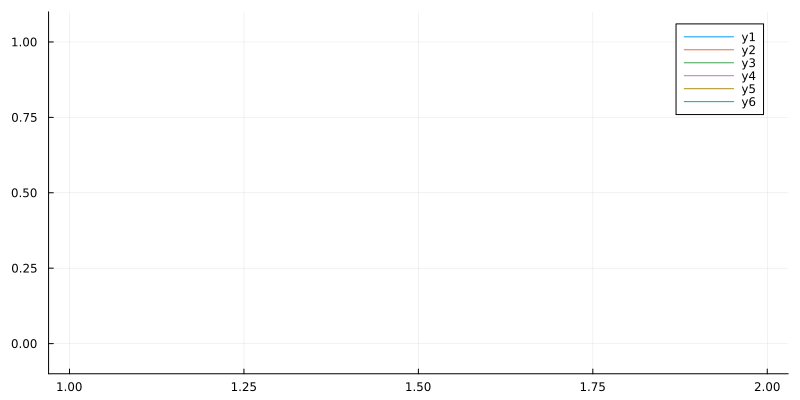

In [485]:
using Plots
plot_us = sol.u[1:100:end]
plot_ts = sol.t[1:100:end]

state_populations = [[real(u[n_states*(i-1) + i]) for u in plot_us] for i ∈ 1:n_states]

n_states = size(p.ρ_soa, 1)
plot(size=(800, 400), ylim=(-0.1, 1.1))
for i in eachindex(state_populations)
    plot!(plot_ts, state_populations[i])
end
plot!()

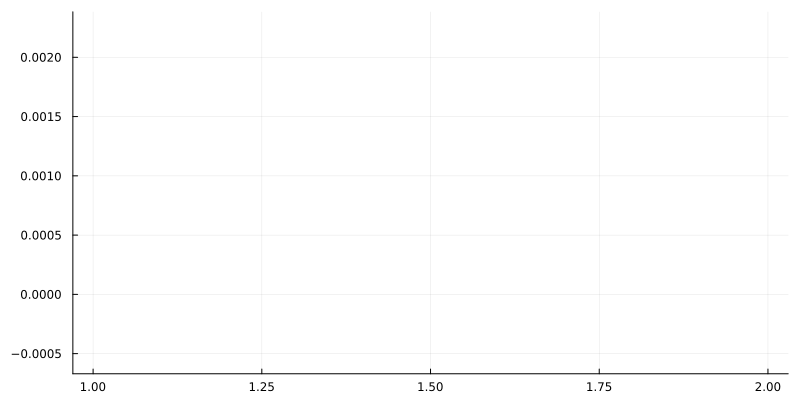

In [486]:
# Plot forces
plot(size=(800, 400), legend=nothing)
plot!(plot_ts, [real(u[end-2]) for u in plot_us])
plot!(plot_ts, [real(u[end-1]) for u in plot_us])
plot!(plot_ts, [real(u[end]) for u in plot_us])
plot!()

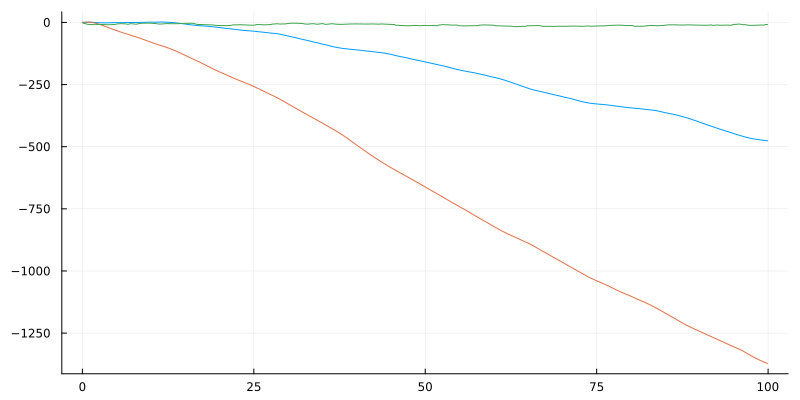

In [472]:
# Plot position
plot(size=(800, 400), legend=nothing)
for i in 1:3
    plot!(plot_ts, [real(u[end-8+i]) for u in plot_us])
end
plot!()

In [478]:
m * Γ^2 * (2π / λ)

0.001536204995265059

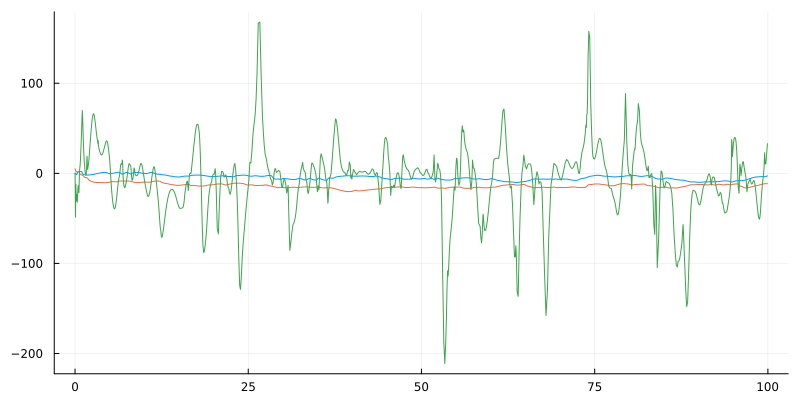

In [473]:
# Plot velocity
plot(size=(800, 400), legend=nothing)
for i in 1:3
    plot!(plot_ts, [real(u[end-5+i]) for u in plot_us])
end
plot!()

In [96]:
using Distributions
uniform_dist = Uniform(0, 2π)
function sample_direction(r=1.0)
    θ = 2π * rand()
    z = rand() * 2 - 1
    return (r * sqrt(1 - z^2) * cos(θ), r * sqrt(1 - z^2) * sin(θ), r * z)
end
;

## Laser cooling force versus velocity

In [97]:
function prob_func!(prob, scan_params, i)
    p = prob.p
    # Update velocity and position
    p.v .= (scan_params[i].v, 0.0, 0.1)
    p.v .= round_vel(p.v, p.freq_res)
    p.r0 .= scan_params[i].r
    return prob
end
function output_func(p, sol)
    f = p.force_last_period
    return (f[1], 0, 0)
end
;

In [98]:
using RectiGrids
di = 7
rs = vcat([(n1*λ/(di+1), n2*λ/(di+1), n3*λ/(di+1)) .* 2π for n1 ∈ 0:di, n2 ∈ 0:di, n3 ∈ 0:di]...)
vs = 0:0.1:7.0

scan_values = (r = rs, v = vs)
scan_values_grid = RectiGrids.grid(scan_values)
;

In [99]:
freq_res = 1e-1
p = obe(ρ0, particle, H.states, lasers, d, d, true, true, λ, Γ, freq_res)

t_end = 5p.period+1; tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p, reltol=1e-5, save_on=false)
;

In [100]:
@time forces, populations = force_scan_v2(prob, scan_values_grid, prob_func!, output_func);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:16


 16.927787 seconds (5.99 M allocations: 1.413 GiB, 0.94% gc time, 136.52% compilation time)


In [101]:
averaged_forces = []
@time for (i,v) ∈ enumerate(vs)
    idxs = [j for (j,x) ∈ enumerate(scan_values_grid) if x.v == v]
    push!(averaged_forces, mean([f[1] for f in forces[idxs]]))
end

  0.078766 seconds (74.85 k allocations: 6.564 MiB, 91.72% compilation time)


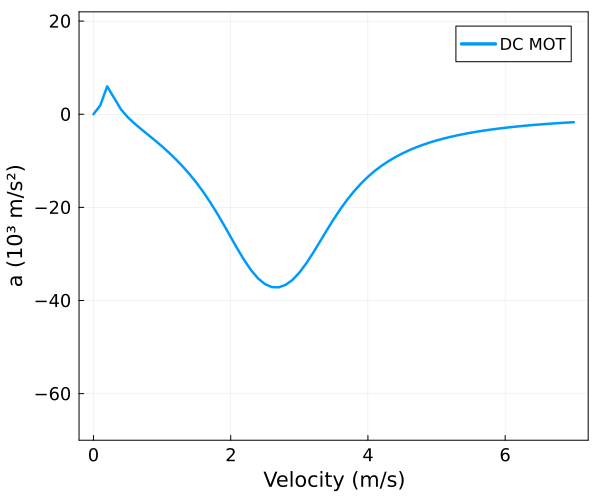

In [102]:
plot(vs, 1e3 .* averaged_forces,
    xlabel="Velocity (m/s)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    labelfontsize=14,
    tickfont=12,
    legendfont=11,
    ylim=(-70,22),
    label="DC MOT",
    size=(600,500)
    )

In [103]:
function prob_func!(prob, scan_params, i)
    p = prob.p
    # Update velocity and position
    p.v .= sample_direction(scan_params.v[i])
    p.v .= round_vel(p.v, p.freq_res)
    p.r0 .= rand(uniform_dist, 3)
    prob
end
function param_func(prob, scan_params, i)
    return scan_params.v[i]
end
function output_func(p, sol)
    f = p.force_last_period
    return (f ⋅ p.v / norm(p.v), 0, 0)
end
;

In [104]:
freq_res = 1e-2
p = obe(ρ0, particle, H.states, lasers, d, d, true, true, λ, Γ, freq_res)

t_end = 10p.period+1; tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p, reltol=1e-4, save_on=false)

n_samples = 100
vs = repeat(collect(0:0.01:1.0), n_samples)

using RectiGrids
scan_values = (v = vs,)
scan_values_grid = RectiGrids.grid(scan_values)
;

In [105]:
@time forces, populations = force_scan_v2(prob, scan_values_grid, prob_func!, output_func);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:13


 13.772997 seconds (1.37 M allocations: 381.922 MiB, 11.91% compilation time)


In [106]:
averaged_forces = []
@time for (i,v) ∈ enumerate(vs)
    idxs = [j for (j,x) ∈ enumerate(scan_values_grid) if x.v == v]
    push!(averaged_forces, mean([f[1] for f in forces[idxs]]))
end

  0.229041 seconds (328.26 k allocations: 63.475 MiB, 30.62% gc time, 23.55% compilation time)


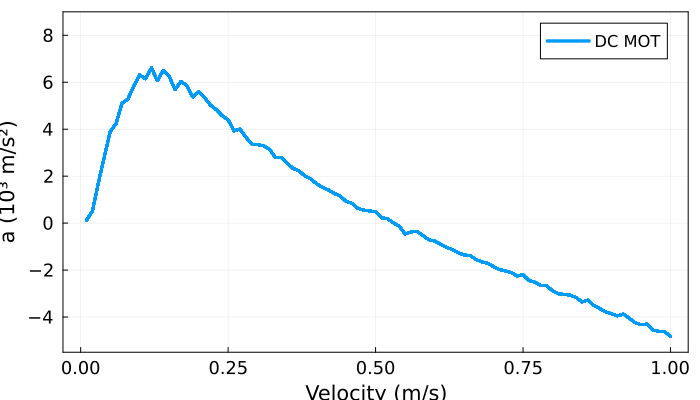

In [107]:
plot(vs, 1e3 .* averaged_forces,
    xlabel="Velocity (m/s)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    labelfontsize=14,
    tickfont=12,
    legendfont=11,
    label="DC MOT",
    ylim=(-5.5,9),
    size=(700,400)
    )

## Laser cooling force versus magnetic field

In [108]:
function prob_func!(prob, scan_params, i)
    p = prob.p
    
    # Update velocity and position
    p.particle.v .= scan_params[i].v
    p.particle.r0 .= scan_params[i].r
    
    # Update magnetic field
    H = p.extra_p.H
    H.parameters.B_z = scan_params[i].B
    evaluate!(H)
    QuantumStates.solve!(H)
    
    # Update transition dipole moments
    update_basis_tdms!(H)
    update_tdms!(H)
    new_d = H.tdms
    
    new_p = obe(p.ρ0, p.particle, H.states, p.extra_p.lasers, new_d, nothing, true, true, p.λ, p.Γ, p.freq_res, p.extra_p)
    
    return remake(prob, p=new_p)
end
function output_func(p, sol)
    f = p.force_last_period
    return f
end
;

In [109]:
using RectiGrids

freq_res = 1e-1
extra_p = (H=H, lasers=lasers)
p = obe(ρ0, particle, H.states, lasers, d, d, true, true, λ, Γ, freq_res, extra_p)

t_end = 10p.period+1; tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p, reltol=1e-4, save_on=false)

Bs = (0:0.2:2.0)
di = 7
rs = vcat([(n1*λ/(di+1), n2*λ/(di+1), n3*λ/(di+1)) .* 2π for n1 ∈ 0:di, n2 ∈ 0:di, n3 ∈ 0:di]...)
vs = [sample_direction(0) for _ in 1:1]

scan_values = (B = Bs, r = rs, v = vs)
scan_values_grid = RectiGrids.grid(scan_values)
;

In [110]:
@time forces, populations = force_scan_v2(prob, scan_values_grid, prob_func!, output_func);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


  4.551220 seconds (6.75 M allocations: 667.330 MiB, 1.48% gc time, 1317.48% compilation time)


In [111]:
averaged_forces = []
@time for (i,B) ∈ enumerate(Bs)
    idxs = [j for (j,x) ∈ enumerate(scan_values_grid) if x.B == B]
    push!(averaged_forces, mean([f[3] for f in forces[idxs]]))
end

  0.084693 seconds (77.91 k allocations: 5.421 MiB, 98.52% compilation time)


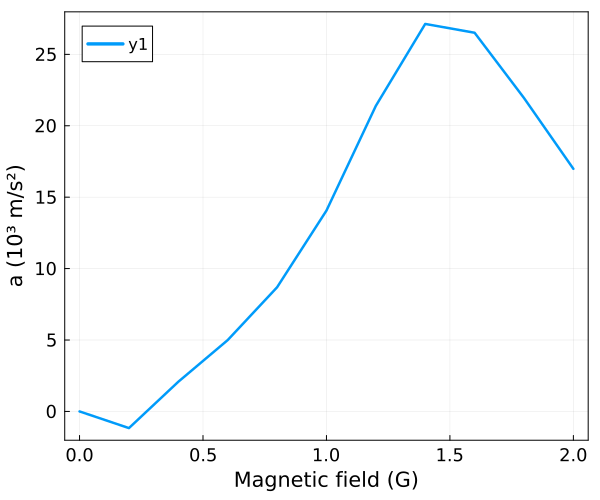

In [112]:
plot(Bs, 1e3 .* averaged_forces,
    xlabel="Magnetic field (G)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    labelfontsize=14,
    tickfont=12,
    legendfont=11,
    # ylim=(-3,23),
    size=(600,500)
    )

In [75]:
averaged_populations = []
@time for (i,B) ∈ enumerate(Bs)
    idxs = [j for (j,x) ∈ enumerate(scan_values_grid) if x.B == B]
    push!(averaged_populations, mean([p for p in populations[idxs,:]], dims=1))
end

  0.068423 seconds (52.41 k allocations: 4.004 MiB, 98.70% compilation time)


In [76]:
averaged_populations[3]'

6×1 adjoint(::Matrix{Float64}) with eltype Float64:
 0.28297247107836265
 0.36824454186429534
 0.31845597695666417
 0.015506087104266285
 0.008417312043617805
 0.006403610952793673